# Deep learning for automatic violence detection: tests on the Hockey Fight and Crowd Violence datasets

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/airtlab/violence-detection-tests-on-the-airtlab-dataset/blob/master/notebook/Violence_Detection_on_the_Hockey_Fight_and_Crowd_Violence_Datasets.ipynb)

This notebook contains the source code of the experiments presented in 
> P. Sernani, N. Falcionelli, S. Tomassini, P. Contardo and A. F. Dragoni, "Deep Learning for Automatic Violence Detection: Tests on the AIRTLab Dataset," in IEEE Access, vol. 9, pp. 160580-160595, 2021, doi: 10.1109/ACCESS.2021.3131315.

The paper is open access and available here: [https://ieeexplore.ieee.org/document/9627980](https://ieeexplore.ieee.org/document/9627980).

The experiments are **accuracy tests of three different deep neural networks**  based on 3D Convolutional Neural Network (3D CNN) and ConvLSTM architectures. In this notebook, such models perform a classification on the samples of the **Hockey Fight** and **Crowd Violence** datasets.

The Hockey Fight dataset is described in
> E. Bermejo Nievas, O. Deniz Suarez, G. Bueno García, and R. Sukthankar, *Violence detection in video using computer vision techniques*, in Computer Analysis of Images and Patterns, P. Real, D. Diaz-Pernil, H. Molina-Abril, A. Berciano, and W. Kropatsch, Eds. Berlin, Heidelberg: Springer Berlin Heidelberg, 2011, pp. 332–339.

The Crowd Violence dataset is described in
> T. Hassner, Y. Itcher, and O. Kliper-Gross, *Violent flows: Real-time detection of violent crowd behavior*, in 2012 IEEE Computer Society Conference on Computer Vision and Pattern Recognition Workshops, 2012, pp. 1–6.

**This notebook assumes** that **the orginal archives of the two datasets** ("HockeyFights.zip" and "movies.rar" for the Hockey Fight and the Crowd Violence respectively) are located **into a "My Drive/ViolenceDetectionDatasets" folder inside Google Drive**. In fact, as we do not own and developed these two datasets, we do not re-distribute them.

We tested three different models:
1. the first model uses [C3D](https://arxiv.org/abs/1412.0767) a 3D CNN pre-trained on the [Sport-1M dataset](https://cs.stanford.edu/people/karpathy/deepvideo/), as a feature extractor and an SVM a classifier. We use the C3D original weights, without retraining, therefore applying transfer learning. Only the SVM is trained from scratch on the two datasets.
2. the second model also uses C3D until the first fully connected layer, adding two fully connected layers to obtain an end-to-end network for classification. We use the C3D original weights, without training again, therefore applying transfer learning. Only the two final fully connected layer are trained from scratch on the two datasets.
3. the third model is based on the [ConvLSTM architecture](https://arxiv.org/abs/1506.04214), followed by two fully connected layers, getting an end-to-end network for classification. The entire network is trained from scratch on the two datasets.

### Note

The results presented in the paper are computed with a **GPU runtime**. **5 randomized tests for each model** were performed, to generalize the performance of the proposed model. Due to the randomization of the dataset splitting and non-deterministic behaviour of GPU computation, the results can slightly change across different runs.

For more information about non-determism on GPU with TensorFlow check <https://github.com/NVIDIA/framework-determinism>.

## 1 Preliminary Operations
The following cells:
- **download the C3D weights** from <https://github.com/aslucki/C3D_Sport1M_keras>;
- **mount google drive** in the notebook disk. The archive of the two dataset are assumed to be in a directory "ViolenceDetectionDatasets" into the "My Drive" folder.;
- *unzip the Hockey Fight dataset* into a "/hockeyFight" folder;
- *unzip the Crowd Violence dataset* into a "/crowdViolence" folder;
- define the architecture of the **C3D model**, as described by [Tran et al.](https://arxiv.org/abs/1412.0767);
- define some utility functions to **load the C3D weights**, pre-process the dataset videos to get 16-frames chunks at a resolution of 112 x 112, and extract the features with C3D.
- count the 16-frames chunks available in the two datasets.

In [ ]:
# downloads C3D weights from https://github.com/aslucki/C3D_Sport1M_keras
!mkdir weights
!gdown --id 1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm -O weights/weights.h5

Downloading...
From: https://drive.google.com/uc?id=1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm
To: /content/weights/weights.h5
320MB [00:08, 39.4MB/s]


In [ ]:
# mounts drive and unzip hockey fight and crowd violence datasets to local machine

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# creates a directory to store the hockey fight videos and unzips the hockey fight archive there
!rm -rf /hockeyFight
!mkdir /hockeyFight

!unzip /content/drive/My\ Drive/ViolenceDetectionDatasets/HockeyFights.zip -d /hockeyFight


Archive:  /content/drive/My Drive/ViolenceDetectionDatasets/HockeyFights.zip
  inflating: /hockeyFight/no499_xvid.avi  
  inflating: /hockeyFight/no498_xvid.avi  
  inflating: /hockeyFight/no497_xvid.avi  
  inflating: /hockeyFight/no496_xvid.avi  
  inflating: /hockeyFight/no495_xvid.avi  
  inflating: /hockeyFight/no493_xvid.avi  
  inflating: /hockeyFight/no494_xvid.avi  
  inflating: /hockeyFight/no492_xvid.avi  
  inflating: /hockeyFight/no491_xvid.avi  
  inflating: /hockeyFight/no490_xvid.avi  
  inflating: /hockeyFight/no489_xvid.avi  
  inflating: /hockeyFight/no488_xvid.avi  
  inflating: /hockeyFight/no486_xvid.avi  
  inflating: /hockeyFight/no487_xvid.avi  
  inflating: /hockeyFight/no485_xvid.avi  
  inflating: /hockeyFight/no484_xvid.avi  
  inflating: /hockeyFight/no482_xvid.avi  
  inflating: /hockeyFight/no483_xvid.avi  
  inflating: /hockeyFight/no481_xvid.avi  
  inflating: /hockeyFight/no480_xvid.avi  
  inflating: /hockeyFight/no479_xvid.avi  
  inflating: /hockey

In [ ]:
# creates a directory to store the crowd violence videos and unzips the crowd violence archive there
!rm -rf /crowdViolence
!mkdir /crowdViolence

!unrar x /content/drive/My\ Drive/ViolenceDetectionDatasets/movies.rar /crowdViolence


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/ViolenceDetectionDatasets/movies.rar

Creating    /crowdViolence/1                                          OK
Creating    /crowdViolence/1/NonViolence                              OK
Extracting  /crowdViolence/1/NonViolence/football_crowds_cheering__Andres_Iniesta_Standing_Ovations__allas11__WKv7pmjgDeg.avi       0%  OK 
Extracting  /crowdViolence/1/NonViolence/football_crowds_cheering__Arkansas_vs_ULM_September_11_2010_Woo_Pig_Sooie__jayd243__RfMRWT.avi       0%  OK 
Extracting  /crowdViolence/1/NonViolence/football_crowds_cheering__Australia_vs_Ghana__cubicspacedivision__hy9sgs_Rzbg.avi       0%  1%  OK 
Extracting  /crowdViolence/1/NonViolence/football_crowds_cheering__Cal_Beats_Stanford_Big_Game_2002_short_low_res_version__belmonto.avi       1%  OK 
Extracting  /crowdViolence/1/NonViolence/football_crowds_cheering__Chang_Rai_United_Fo

In [ ]:
# C3D definition
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D

def create_C3D_model(summary = False):
    """Creates model object with the sequential API: https://keras.io/models/sequential/
        
    Parameters
    ----------
    summary : bool
              if True, prints the model summary (default False)

    Returns
    -------
    model : Sequential
            The instantiated model
    """

    model = Sequential()
    input_shape = (16, 112, 112, 3)

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                     padding='same', name='conv1',
                     input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    if summary:
      print(model.summary())

    return model

In [ ]:
# Utility functions for the experiments (chunk count, video preprocessing, feature computation)
from keras.models import model_from_json, Model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

def getFeatureExtractor(weigthsPath, layer, verbose = False):
    """Gets the C3D feature extractor

    Parameters
    ----------
    weightsPath : str
                  Pathname of the weights file for the C3D model.
    layer : str
            Name of the output layer for the feature extractor
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------

    Model : Model class
            Feature extractor

    """

    model = create_C3D_model(verbose)
    model.load_weights(weigthsPath)
    model.compile(loss='mean_squared_error', optimizer='sgd')

    return Model(inputs=model.input,outputs=model.get_layer(layer).output)

def count_hockey_fight_chunks(videoBasePath):
    """Counts the 16 frames lenght chunks available in the HockeyFight dataset,
    unzipped at videoBasePath.

    Parameters
    ----------
    videoBasePath : str
                    Base path of the dataset

    Returns
    -------
    cnt : int
          number of 16 frames lenght chunks in the dataset
    """

    cnt = 0

    videofiles = os.listdir(videoBasePath)
    for videofile in videofiles:
        # print(videofile)
        filePath = os.path.join(videoBasePath, videofile)
        video = cv2.VideoCapture(filePath)
        numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        chunks = numframes//16
        cnt += chunks
    

    return cnt

def count_crowd_violence_chunks(videoBasePath):
    """Counts the 16 frames lenght chunks available in the Crowd Violence dataset,
    unzipped at videoBasePath and organized in five folder (1, 2, 3, 4, 5), divided
    into "Violence" and "NonViolence"

    Parameters
    ----------
    videoBasePath : str
                    Base path of the dataset

    Returns
    -------
    cnt : int
          number of 16 frames lenght chunks in the dataset
    """

    folders = ['1', '2', '3', '4', '5']
    subFolders = ['NonViolence', 'Violence']
    cnt = 0

    for folder in folders:
        for subFolder in subFolders:
            path = os.path.join(videoBasePath, folder, subFolder)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                # print(path + '/' + videofile)
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                # The following video file returns wrong metadata, there are less framex (i.e. lower frame rate and count than returned!)
                if videofile == 'football_crowds_cheering__Goldfellas_GT_vs_Maryland_1999_Crowd_Shot__tonyanddanielleoliva__xiCWDdaUSbg.avi':
                    numframes = 81
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                cnt += chunks
    

    return cnt

def preprocessHockeyFightVideos(videoBasePath, featureBasePath, verbose=True):
    """Preproccess all the videos.

    It extracts samples for the input of C3D from the Hockey Fight video dataset at videoBasePath.
    Therefore, all the videos are assumed to be in videoBasePath, with the violent ones named as
    "fi" (fight) and the non-violent one named "no" (no fight). The samples and the labels are stored
    in two memmap numpy arrays, called samples.mmap and labels.mmap, at "featureBasePath".
    The numpy array with samples has shape (Chunk #, 16, 112, 112, 3), the labels array has shape (Chunk # 16, 112, 112, 3).
    For the Hockey Fight Dataset the number of chunks is 2007.

    Parameters
    ----------
    videoBasePath : str
                    Pathname to the base of the Hocky Fight Dataset.
    featureBasePath : str
                      it is the pathname of a base where the numpy arrays have to be saved.
    verbose : bool
              if True print debug logs (default True)
              
    """

    total_chunks = count_hockey_fight_chunks(videoBasePath)
    npSamples = np.memmap(os.path.join(featureBasePath, 'samples.mmap'), dtype=np.float32, mode='w+', shape=(total_chunks, 16, 112, 112, 3))
    npLabels = np.memmap(os.path.join(featureBasePath, 'labels.mmap'), dtype=np.int8, mode='w+', shape=(total_chunks))
    cnt = 0

    videofiles = os.listdir(videoBasePath)
    for videofile in videofiles:
        filePath = os.path.join(videoBasePath, videofile)
        video = cv2.VideoCapture(filePath)
        numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        chunks = numframes//16
        if verbose:
            print(filePath)
            print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
        vid = []
        videoFrames = []
        while True:
            ret, img = video.read()
            if not ret:
                break
            videoFrames.append(cv2.resize(img, (112, 112)))
        vid = np.array(videoFrames, dtype=np.float32)
        filename = os.path.splitext(videofile)[0]
        chunk_cnt = 0
        for i in range(chunks):
            X = vid[i*16:i*16+16]
            chunk_cnt += 1
            npSamples[cnt] = np.array(X, dtype=np.float32)
            if videofile.startswith('fi'):
                npLabels[cnt] = np.int8(1)
            else:
                npLabels[cnt] = np.int8(0)
            cnt += 1 

    if verbose:
        print("** Labels **")
        print(npLabels.shape)
        print('\n****\n')
        print("** Samples **")
        print(npSamples.shape)
        print('\n****\n')

    del npSamples
    del npLabels

def preprocessCrowdViolenceVideos(videoBasePath, featureBasePath, verbose=True):
    """Preproccess all the videos.

    It extracts samples for the input of C3D from the crowd violence dataset, 
    placed into videoBasePath. Therefore, the dataset is assumed organised in 
    5 folders (named 1, 2, 3, 4, 5) divided into "NonViolence" and "Violence"
    subfolders. The samples and the labels are stored in two memmap numpy arrays,
    called samples.mmap and labels.mmap, at "featureBasePath".
    The numpy array with samples has shape (Chunk #, 16, 112, 112, 3),
    the labels array has shape (Chunk # 16, 112, 112, 3).
    For the Crowd Violence Dataset the number of chunks is 1265.

    Parameters
    ----------
    videoBasePath : str
                    Pathname to the base of the Crowd Violence dataset.
    featureBasePath : str
                      it is the pathname of a base where the numpy arrays have to be saved.
    verbose : bool
              if True print debug logs (default True)
              
    """

    folders = ['1', '2', '3', '4', '5']
    subFolders = ['NonViolence', 'Violence']
    total_chunks = count_crowd_violence_chunks(videoBasePath)
    npSamples = np.memmap(os.path.join(featureBasePath, 'samples.mmap'), dtype=np.float32, mode='w+', shape=(total_chunks, 16, 112, 112, 3))
    npLabels = np.memmap(os.path.join(featureBasePath, 'labels.mmap'), dtype=np.int8, mode='w+', shape=(total_chunks))
    cnt = 0

    for folder in folders:
        for subFolder in subFolders:
            path = os.path.join(videoBasePath, folder, subFolder)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

                # The following video file returns wrong metadata, there are less framex (i.e. lower frame rate and count than returned!)
                if videofile == 'football_crowds_cheering__Goldfellas_GT_vs_Maryland_1999_Crowd_Shot__tonyanddanielleoliva__xiCWDdaUSbg.avi':
                    numframes = 81
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))

                vid = np.array(videoFrames, dtype=np.float32)
                filename = os.path.splitext(videofile)[0]
                chunk_cnt = 0
                for i in range(chunks):
                    X = vid[i*16:i*16+16]

                    if X.shape[0] == 16:
                      chunk_cnt += 1
                      npSamples[cnt] = np.array(X, dtype=np.float32)
                      if subFolder == 'Violence':
                          npLabels[cnt] = np.int8(1)
                      else:
                          npLabels[cnt] = np.int8(0)
                      cnt += 1
                    else:
                      if verbose:
                        print('Wrong chunck lenght: ' + str(i) + ' - ' + str(X.shape) + ' - ' + str(len(videoFrames)) + ' - ' + str(len(vid)))

    if verbose:
        print("** Labels **")
        print(npLabels.shape)
        print('\n****\n')
        print("** Samples **")
        print(npSamples.shape)
        print('\n****\n')

    del npSamples
    del npLabels

def extractFeaturesFromHockeyFight(weigthsPath, videoBasePath, featureBasePath='', verbose=True):
    """Extracts features from the Hockey Fight video dataset, using fc6 of the C3D network.

    It extracts features from the Hockey Fight video dataset. Therefore all the videos
    are assumed to be in the same folder, with the violent video names starting with "fi" (fight)
    and the non violent video names starting with "no" (no fight).

    Parameters
    ----------
    weightsPath : str
                  Pathname of the weights file for the C3D model.
    videoBasePath : str
                    Pathname to the Hockey Fight dataset.
    featureBasePath : str
                      if non-empty, it is the pathname of a base where numpy array has to be saved.
                      It is assumed to be organized as the hockey fight dataset.
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """

    featureExtractor = getFeatureExtractor(weigthsPath, 'fc6', verbose)

    labels = []
    features = []

    videofiles = os.listdir(videoBasePath)
    for videofile in videofiles:
        filePath = os.path.join(videoBasePath, videofile)
        video = cv2.VideoCapture(filePath)
        numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        chunks = numframes//16
        if verbose:
            print(filePath)
            print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
        vid = []
        videoFrames = []
        while True:
            ret, img = video.read()
            if not ret:
                break
            videoFrames.append(cv2.resize(img, (112, 112)))
        vid = np.array(videoFrames, dtype=np.float32)

        filename = os.path.splitext(videofile)[0]
        if featureBasePath:
            featureFilePath = os.path.join(featureBasePath, filename + '.csv')
            with open(featureFilePath, 'ab') as f:
                for i in range(chunks):
                    X = vid[i*16:i*16+16]
                    out = featureExtractor.predict(np.array([X]))
                    np.savetxt(f, out)
                    out = out.reshape(4096)
                    features.append(out)
                    if videofile.startswith('fi'):
                        labels.append(1)
                    else:
                        labels.append(0)
            
            if verbose:
                print('*** Saved file: ' + featureFilePath)
                print('\n')
        else:
            for i in range(chunks):
                X = vid[i*16:i*16+16]
                out = featureExtractor.predict(np.array([X]))
                out = out.reshape(4096)
                features.append(out)
                if videofile.startswith('fi'):
                    labels.append(1)
                else:
                    labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y

def extractFeaturesFromCrowdViolence(weigthsPath, videoBasePath, featureBasePath='', verbose=True):
    """Extracts features from the Crowd Violence dataset, using fc6 of the C3D network.

    It extracts features from the Crowd Violence dataset. Therefore the dataset is assumed
    to be organized in 5 folders (named '1', '2', '3', '4', '5') divided into to subfolders, 
    i.e. "NonViolence" and "Violence"

    Parameters
    ----------
    weightsPath : str
                  Pathname of the weights file for the C3D model.
    videoBasePath : str
                    Pathname to the base of the Crowd Violence dataset.
    featureBasePath : str
                      if non-empty, it is the pathname of a base where numpy array has to be saved.
                      It is assumed organized as the Crowd Violence dataset.
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """

    featureExtractor = getFeatureExtractor(weigthsPath, 'fc6', verbose)

    folders = ['1', '2', '3', '4', '5']
    subFolders = ['NonViolence', 'Violence']
    labels = []
    features = []

    for folder in folders:
        for subFolder in subFolders:
            path = os.path.join(videoBasePath, folder, subFolder)
            featurepath = os.path.join(featureBasePath, folder, subFolder)

            videofiles = os.listdir(path)
            for videofile in videofiles:
                filePath = os.path.join(path, videofile)
                video = cv2.VideoCapture(filePath)
                numframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                # The following video file returns wrong metadata, there are less framex (i.e. lower frame rate and count than returned!)
                if videofile == 'football_crowds_cheering__Goldfellas_GT_vs_Maryland_1999_Crowd_Shot__tonyanddanielleoliva__xiCWDdaUSbg.avi':
                    numframes = 81
                fps = int(video.get(cv2.CAP_PROP_FPS))
                chunks = numframes//16
                if verbose:
                    print(filePath)
                    print("*** [Video Info] Number of frames: {} - fps: {} - chunks: {}".format(numframes, fps, chunks))
                vid = []
                videoFrames = []
                while True:
                    ret, img = video.read()
                    if not ret:
                        break
                    videoFrames.append(cv2.resize(img, (112, 112)))
                vid = np.array(videoFrames, dtype=np.float32)

                filename = os.path.splitext(videofile)[0]
                if featureBasePath:
                    featureFilePath = os.path.join(featurepath, filename + '.csv')
                    with open(featureFilePath, 'ab') as f:
                        for i in range(chunks):
                            X = vid[i*16:i*16+16]
                            out = featureExtractor.predict(np.array([X]))
                            np.savetxt(f, out)
                            out = out.reshape(4096)
                            features.append(out)
                            if subFolder == 'Violence':
                                labels.append(1)
                            else:
                                labels.append(0)
                    
                    if verbose:
                        print('*** Saved file: ' + featureFilePath)
                        print('\n')
                else:
                    for i in range(chunks):
                        X = vid[i*16:i*16+16]
                        out = featureExtractor.predict(np.array([X]))
                        out = out.reshape(4096)
                        features.append(out)
                        if subFolder == 'Violence':
                            labels.append(1)
                        else:
                            labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y

def get_labels_and_features_from_hockey_fight_files(basePath, verbose=True):
    """"Generates the feature array and the labels from saved feature files.

    It generates features and labels from saved features files, organised in a basePath
    directory, with the violent video names starting with "fi" (fight.) and the
    non-violent viode names starting with "no" (no fight).

    Parameters
    ----------
    basePath : str
               Pathname to the base of the feature files repository, organized
               as the Hockey Fight dataset.
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """
    labels = []
    features = []

    textfiles = os.listdir(basePath)
    for textfile in textfiles:
        filePath = os.path.join(basePath, textfile)
        chunks = np.loadtxt(filePath)
        for chunk in chunks:
          features.append(chunk)
          if textfile.startswith('fi'):
            labels.append(1)
          else:
            labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y

def get_labels_and_features_from_crowd_violence_files(basePath, verbose=True):
    """"Generates the feature array and the labels from saved feature files.

    It generates features and labels from saved features files, organised in five
    folders (1, 2, 3, 4, 5) divided into two subfolders ("NonViolence" and "Violence").

    Parameters
    ----------
    basePath : str
               Pathname to the base of the feature files repository, organized
               as the Crowd Violence dataset.
    verbose : bool
              if True print debug logs (default True)

    Returns
    -------
    X : numpy.ndarray
        Features array of shape (Num of video chunks, 4096) representing the 4096-dim feature vector for each video 
        chunk in the dataset
    y : numpy.ndarray
        Labels array of shape (Num of video chunks) representing the labels for all the video chunks in the dataset
        (1 = violent, 2 = non violent)
              
    """

    folders = ['1', '2', '3', '4', '5']
    subFolders = ['NonViolence', 'Violence']
    labels = []
    features = []

    for folder in folders:
        for subFolder in subFolders:
            path = os.path.join(basePath, folder, subFolder)

            textfiles = os.listdir(path)
            for textfile in textfiles:
                filePath = os.path.join(path, textfile)
                chunks = np.loadtxt(filePath)
                if chunks.ndim > 1:
                  for chunk in chunks:
                    features.append(chunk)
                    if subFolder == 'Violence':
                      labels.append(1)
                    else:
                      labels.append(0)
                else:
                    features.append(chunks)
                    if subFolder == 'Violence':
                      labels.append(1)
                    else:
                      labels.append(0)

    y = np.array(labels)
    X = np.array(features)

    if verbose:
        print("** Labels **")
        # print(y)
        print(y.shape)
        print('\n****\n')
        print("** Features **")
        # print(X)
        print(X.shape)
        print('\n****\n')

    return X, y


In [ ]:
# Counts the 16-frames chunks available in the hockey fight and crowd violence datasets
hockeyFightCount = count_hockey_fight_chunks('/hockeyFight')
print("Hockey Fight Chunks: " + str(hockeyFightCount))

crowdViolenceCount = count_crowd_violence_chunks('/crowdViolence')
print("Crowd Violence Count Chunks: " + str(crowdViolenceCount))

Hockey Fight Chunks: 2007
Crowd Violence Count Chunks: 1265


## 2 Feature Extraction with C3D
The following cells:
- create the folders to store the feature vectors extracted from the video chunks;
- extract the features from the video of the datasets using C3D and save them to csv files in the created folders.

In [ ]:
# folders to store samples and features during the experiments
!rm -rf /csvFeatures
!mkdir /csvFeatures
!mkdir /csvFeatures/hockeyFight
!mkdir /csvFeatures/crowdViolence
!mkdir /csvFeatures/crowdViolence/1
!mkdir /csvFeatures/crowdViolence/2
!mkdir /csvFeatures/crowdViolence/3
!mkdir /csvFeatures/crowdViolence/4
!mkdir /csvFeatures/crowdViolence/5
!mkdir /csvFeatures/crowdViolence/1/Violence
!mkdir /csvFeatures/crowdViolence/1/NonViolence
!mkdir /csvFeatures/crowdViolence/2/Violence
!mkdir /csvFeatures/crowdViolence/2/NonViolence
!mkdir /csvFeatures/crowdViolence/3/Violence
!mkdir /csvFeatures/crowdViolence/3/NonViolence
!mkdir /csvFeatures/crowdViolence/4/Violence
!mkdir /csvFeatures/crowdViolence/4/NonViolence
!mkdir /csvFeatures/crowdViolence/5/Violence
!mkdir /csvFeatures/crowdViolence/5/NonViolence

In [ ]:
extractFeaturesFromHockeyFight('weights/weights.h5', '/hockeyFight', '/csvFeatures/hockeyFight', True)

extractFeaturesFromCrowdViolence('weights/weights.h5', '/crowdViolence', '/csvFeatures/crowdViolence', True)

Output streaming troncato alle ultime 5000 righe.

/hockeyFight/fi180_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/fi180_xvid.csv


/hockeyFight/fi2_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/fi2_xvid.csv


/hockeyFight/fi15_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/fi15_xvid.csv


/hockeyFight/fi309_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/fi309_xvid.csv


/hockeyFight/no318_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/no318_xvid.csv


/hockeyFight/no420_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
*** Saved file: /csvFeatures/hockeyFight/no420_xvid.csv


/hockeyFight/fi408_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - c

(array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.3661956],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.255596 ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 1.1903572, 1.3280798,
         0.1422962],
        [0.       , 0.       , 0.       , ..., 0.       , 1.2987413,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32), array([0, 0, 0, ..., 1, 1, 1]))

## 3 Testing C3D + SVM
The following cells:
- define the code to run the tests 5 times with the C3D + SVM model on the extracted features of the Hockey Fight and Crowd Violence datasets, using a stratified shuffle split cross-validation scheme. Specifically, **80%** of the data is used to **train** the SVM, and the remaining **20%** of the data is used for **testing** the classification accuracy. Note that, in the experiments, **only the SVM is trained** (the weights of C3D are not modified), in a **transfer learning** manner;
- run the tests.

In [ ]:
# Experiment definition for C3D + SVM
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pylab as plt


def runSVMExperiments(get_labels_and_features_from_files, featureBasePath, savedFileName, rState):
    """"Runs the tests with the C3D + SVM architecture

    Parameters
    ----------
    get_labels_and_features_from_files : Callable[[str, bool], void]
               Function that builds numpy arrays with samples and labels from
               saved CSV files
    featureBasePath : str
                      Pathname to the base of the feature files directory.
    savedFileName : str
                    File name to be used to save the AUC-ROC plot.
    rState : int, RandomState instance or None
             Controls the randomness of the training and testing indices produced.
             Pass an int for reproducible output across multiple function calls.
              
    """
    X, y = get_labels_and_features_from_files(featureBasePath, False)
      

    # Cross Validation
    clf = svm.SVC(kernel='linear', C = 1, probability=True)

    nsplits = 5
    #cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
    cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8, random_state=rState)


    tprs = []
    aucs = []
    scores = []
    sens = np.zeros(shape=(nsplits))
    specs = np.zeros(shape=(nsplits))
    f1Scores = np.zeros(shape=(nsplits))
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(num=1, figsize=(10,10))
    i = 1
    for train, test in cv.split(X, y):
        # train = sklearn.utils.shuffle(train)
        clf.fit(X[train], y[train])
        pred_acc = clf.predict(X[test])
        split_acc = accuracy_score(y[test], pred_acc)
        scores.append(split_acc)
        prediction = clf.predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], prediction[:, 1], pos_label=1)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))
        print('confusion matrix split ' + str(i))
        print(confusion_matrix(y[test], pred_acc))

        # y_pred = prediction.argmax(axis=-1)
        report = classification_report(y[test], pred_acc, target_names=['non-violent', 'violent'], output_dict=True)
        sens[i - 1] = report['violent']['recall']
        specs[i - 1] = report['non-violent']['recall']
        f1Scores[i - 1] = report['violent']['f1-score']
        print(classification_report(y[test], prediction.argmax(axis=-1), target_names=['non-violent', 'violent']))
        print('Accuracy: ' + str(split_acc))
        print('\n')
        i += 1
          
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of C3D + SVM model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})

    plt.savefig(savedFileName + '.pdf')
    plt.show()

    print('Accuracies')
    print(scores)
    print('Sensitivities')
    print(sens)
    print('specificities')
    print(specs)
    print('F1-scores')
    print(f1Scores)
    print("Avg accuracy: {0} +/- {1}".format(np.mean(scores, axis=0), np.std(scores, axis=0)))
    print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
    print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
    print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))

confusion matrix split 1
[[195   5]
 [  6 196]]
              precision    recall  f1-score   support

 non-violent       0.97      0.98      0.98       200
     violent       0.98      0.97      0.98       202

    accuracy                           0.98       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.98      0.98      0.98       402

Accuracy: 0.972636815920398


confusion matrix split 2
[[199   1]
 [  6 196]]
              precision    recall  f1-score   support

 non-violent       0.97      0.99      0.98       200
     violent       0.99      0.97      0.98       202

    accuracy                           0.98       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.98      0.98      0.98       402

Accuracy: 0.9825870646766169


confusion matrix split 3
[[195   5]
 [  5 197]]
              precision    recall  f1-score   support

 non-violent       0.97      0.97      0.97       200
     violent       0.98      0.9

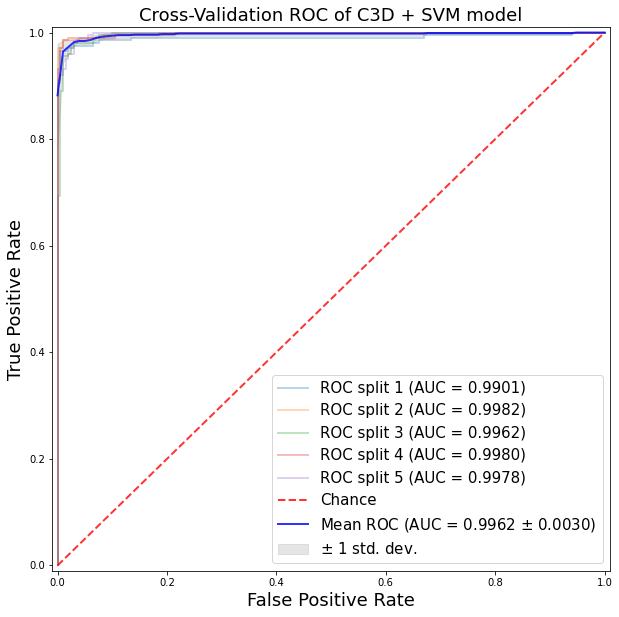

Accuracies
[0.972636815920398, 0.9825870646766169, 0.9751243781094527, 0.9875621890547264, 0.9751243781094527]
Sensitivities
[0.97029703 0.97029703 0.97524752 0.98514851 0.99009901]
specificities
[0.975 0.995 0.975 0.99  0.96 ]
F1-scores
[0.97270471 0.98245614 0.97524752 0.98759305 0.97560976]
Avg accuracy: 0.9786069651741294 +/- 0.005584563263841716
Avg sensitivity: 0.9782178217821782 +/- 0.008043602380827691
Avg specificity: 0.9789999999999999 +/- 0.012409673645990868
Avg f1-score: 0.9787222375900587 +/- 0.005488262618658563


In [ ]:
# C3D + SVM on the Hockey Fight dataset
runSVMExperiments(get_labels_and_features_from_hockey_fight_files, '/csvFeatures/hockeyFight', 'C3D_SVM_Hockey', 42)

confusion matrix split 1
[[107   0]
 [  0 146]]
              precision    recall  f1-score   support

 non-violent       1.00      1.00      1.00       107
     violent       1.00      1.00      1.00       146

    accuracy                           1.00       253
   macro avg       1.00      1.00      1.00       253
weighted avg       1.00      1.00      1.00       253

Accuracy: 1.0


confusion matrix split 2
[[105   2]
 [  0 146]]
              precision    recall  f1-score   support

 non-violent       1.00      0.98      0.99       107
     violent       0.99      1.00      0.99       146

    accuracy                           0.99       253
   macro avg       0.99      0.99      0.99       253
weighted avg       0.99      0.99      0.99       253

Accuracy: 0.9920948616600791


confusion matrix split 3
[[107   0]
 [  0 146]]
              precision    recall  f1-score   support

 non-violent       1.00      1.00      1.00       107
     violent       1.00      1.00      1.00   

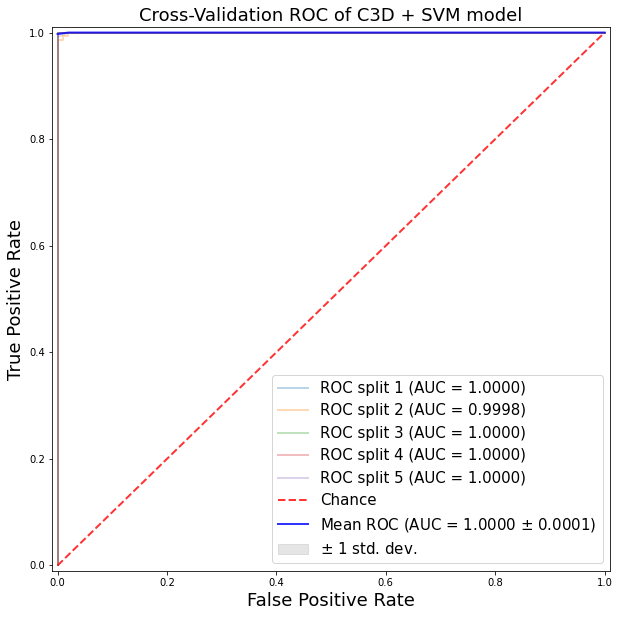

Accuracies
[1.0, 0.9920948616600791, 1.0, 1.0, 0.9881422924901185]
Sensitivities
[1. 1. 1. 1. 1.]
specificities
[1.         0.98130841 1.         1.         0.97196262]
F1-scores
[1.         0.99319728 1.         1.         0.98983051]
Avg accuracy: 0.9960474308300394 +/- 0.004999648474574519
Avg sensitivity: 1.0 +/- 0.0
Avg specificity: 0.9906542056074766 +/- 0.01182159872960142
Avg f1-score: 0.9966055574772282 +/- 0.004291488596995241


In [ ]:
# C3D + SVM on the Crowd Violence dataset
runSVMExperiments(get_labels_and_features_from_crowd_violence_files, '/csvFeatures/crowdViolence', 'C3D_SVM_Crowd', 42)


## 4 Video Pre-Processing for End-to-End Networks
The following cells execute the pre-processing on all the videos, transforming them into **16-frames** samples at a resolution of **112 x 112**. The samples (and their labels) are stored into two [memmaps](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html) at the "/hockeyFightMMaps" and "/crowdViolenceMMaps" paths, "**samples.mmap**" and **"labels.mmap**", to prevent the loading of **all the samples in memory** at the same time.



In [ ]:
!rm -rf '/crowdViolenceMMaps'
!rm -rf '/hockeyFightMMaps'

!mkdir '/crowdViolenceMMaps'
!mkdir '/hockeyFightMMaps'

In [ ]:
preprocessHockeyFightVideos('/hockeyFight', '/hockeyFightMMaps', True)

/hockeyFight/no104_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no310_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no215_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/fi173_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/fi347_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/fi297_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no256_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no387_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/fi274_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/fi352_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no122_xvid.avi
*** [Video Info] Number of frames: 41 - fps: 25 - chunks: 2
/hockeyFight/no449_xvid.avi
*** 

In [ ]:
preprocessCrowdViolenceVideos('/crowdViolence', '/crowdViolenceMMaps', True)

/crowdViolence/1/NonViolence/stadium_crowds__Bands_talk_about_their_influences_from_Punk_s_Not_Dead__PNDmovie.avi
*** [Video Info] Number of frames: 92 - fps: 25 - chunks: 5
/crowdViolence/1/NonViolence/peaceful_football_crowds__MaximsNewsNetwork_SUDAN_ELECTIONS_YASIR_ARMAN_OMAR_AL_BASHIR_UNM.avi
*** [Video Info] Number of frames: 70 - fps: 25 - chunks: 4
/crowdViolence/1/NonViolence/stadium_crowds__USC_Football_Team_arriving_at_Lincoln_stadium_2007__jmsotojr__um.avi
*** [Video Info] Number of frames: 81 - fps: 25 - chunks: 5
/crowdViolence/1/NonViolence/stadium_crowds__Jump_Around_at_the_Camp_Randall_Outdoor_Hockey_Classic__ernste40.avi
*** [Video Info] Number of frames: 59 - fps: 25 - chunks: 3
/crowdViolence/1/NonViolence/football_crowds_cheering__FIFA_2010_USA_v_ENG_Dupont_Cirlce_Washington_DC__icallmyselfbria.avi
*** [Video Info] Number of frames: 52 - fps: 29 - chunks: 3
/crowdViolence/1/NonViolence/stadium_crowds__Outside_Yankee_Stadium_Following_World_Series_Win_vs_Phillies_11.

## 5 Testing End-to-End Networks
The following cells
- define **two end-to-end models** and the code to run the experiments on such models; as with C3D + SVM, the experiments are tests repeated **5 times** with the **stratified shuffle split** cross-validation scheme. In each split 80% of data are used for training, and 20% of data are used for testing. 12,5% of the training data (i.e. 10% of the entire dataset) is used for validation. In other words, in each test **70%** of data are actually for **training**, **10%** for **validation**, and **20%** for **testing**.
- run the experiments with the end-to-end model composed by **C3D and two fully connected layers**, on the Hockey Fight and Crowd Violence datasets;
- run the experiments with the end-to-end model based on the **ConvLSTM** architecture (with two fully connected layers for classification), on the Hockey Fight and Crowd Violence datasets.

### 5.1 C3D (until "fc6") + Fully Connected Layers

The following table shows the layers of the end to end model composed of C3D (until the first fully connected layer - fc6) and two fully-connected layers for classification. Note that, in the experiments, **only the last two dense layers are trained** (the weights of C3D are not modified), in a **transfer learning** manner.

| Layer Type                                     | Output Shape             | Parameter # |
|:-----------------------------------------------|:-------------------------|------------:|
| Conv3D, *3x3x3*, *stride=1*                    | (None, 16, 112, 112, 64) |        5248 |
| MaxPooling3D, *1x2x2*                          | (None, 16, 56, 56, 64)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 16, 56, 56, 128)  |      221312 |
| MaxPooling3D, *2x2x2*                          | (None, 8, 28, 28, 128)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 8, 28, 28, 256)   |      884992 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 8, 28, 28, 256)   |     1769728 |
| MaxPooling3D, *2x2x2*                          | (None, 4, 14, 14, 256)   |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 4, 14, 14, 512)   |     3539456 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 4, 14, 14, 512)   |     7078400 |
| MaxPooling3D, *2x2x2*                          | (None, 2, 7, 7, 512)     |           0 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 2, 7, 7, 512)     |     7078400 |
| Conv3D, *3x3x3*, *stride=1*                    | (None, 2, 7, 7, 512)     |     7078400 |
| ZeroPadding3D                                  | (None, 2, 8, 8, 512)     |           0 |
| MaxPooling3D, *2x2x2*                          | (None, 1, 4, 4, 512)     |           0 |
| Flatten                                        | (None, 8192)             |           0 |
| Dense, *4096 units*, *ReLU activation*         | (None, 4096)             |    33558528 |
| Dropout, *0.5*                                 | (None, 4096)             |           0 |
| Dense, *512 units*, *ReLU activation*          | (None, 512)              |     2097664 |
| Dropout, *0.5*                                 | (None, 512)              |           0 |
| Dense,  *1 unit*, *Sigmoid activation*         | (None, 1)                |         513 |


### 5.2 End-to-End ConvLSTM
The following table shows the layers of the end-to-end model based on the ConvLSTM architecture. Note that **the entire network is trained**.

| Layer Type                                     | Output Shape         | Parameter # |
|:-----------------------------------------------|:---------------------|------------:|
| ConvLSTM2D, *64 3x3 filters*                   | (None, 110, 110, 64) |      154624 |
| Dropout, *0.5*                                 | (None, 110, 110, 64) |           0 |
| Flatten                                        | (None, 774400)       |           0 |
| Dense, *256 units*, *ReLU activation*          | (None, 256)          |   198246656 |
| Dropout, *0.5*                                 | (None, 256)          |           0 |
| Dense,  *1 unit*, *Sigmoid activation*         | (None, 1)            |         267 |


In [ ]:
# definitions of the two end-to-end models + definitions of experiments
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
import os
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, ConvLSTM2D


def getC3DCNNModel(verbose=True):
    """Creates the C3D + fully connected layers end-to-end model object with the
    sequential API: https://keras.io/models/sequential/

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)

    Returns
    -------
    model : Sequential
            The instantiated model
    """
    pretrainedModel = getFeatureExtractor('weights/weights.h5', 'fc6', False)
    for layer in pretrainedModel.layers:
        layer.trainable = False

    dropout1 = Dropout(.5)(pretrainedModel.output)
    fc7Alt = Dense(512, activation='relu', name='fc7-alt')(dropout1)
    dropout2 = Dropout(.5)(fc7Alt)
    output = Dense(1, activation='sigmoid')(dropout2)
    model = Model(inputs=pretrainedModel.inputs, outputs=output)
    if verbose:
        model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    del pretrainedModel

    return model

def getLSTMModel(verbose=True):
    """Creates the ConvLSTM + fully connected layers end-to-end model object
    with the sequential API: https://keras.io/models/sequential/

    Parameters
    ----------
    verbose : bool
              if True prints the model summary (default True)

    Returns
    -------
    model : Sequential
            The instantiated model
    """
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3,3), input_shape=(16,112,112,3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    if verbose:
        model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def runEndToEndExperiment(getModel, batchSize, datasetBasePath, count_chunks, mmapDatasetBasePath, samplesMMapName, lablesMMapName, endToEndModelName, savedFileName, rState):
    """"Runs the tests with end to end models.

    Parameters
    ----------
    getModel : Callable[[bool], Sequential]
               Function that instantiates the model to be tested
    batchSize : int
                Batch size to be used for training and testing
    datasetBasePath : str
                      Pathname to the base of the feature files repository.
    count_chunks : Callable[[], int]
                      Function that count the 16-frame chunks in the dataset.
    mmapDatasetBasePath : str
                          Folder including the memory maps of samples and labels.
    samplesMMapName : str
                      Name of the file storing the numpy array of the samples,
                      with shape (Sample #, 16, 112, 112, 3).
    lablesMMapName : str
                     Name of the file storing the numpy array of the labels,
                     with shape (Sample #,).
    endToEndModelName : str
                        Model name to be used in the AUC-ROC plot.
    savedFileName : str
                    File name to be used to save the AUC-ROC plot.
    rState : int, RandomState instance or None
             Controls the randomness of the training and testing indices produced.
             Pass an int for reproducible output across multiple function calls.
              
    """
    chunk_number = count_chunks(datasetBasePath)
    X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 112, 112, 3))
    y = np.memmap(os.path.join(mmapDatasetBasePath, lablesMMapName), mode='r', dtype=np.int8, shape=(chunk_number))
    
    nsplits = 5
    #cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
    cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8, random_state = rState)

    tprs = []
    aucs = []
    scores = []
    sens = np.zeros(shape=(nsplits))
    specs = np.zeros(shape=(nsplits))
    f1Scores = np.zeros(shape=(nsplits))
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(num=1, figsize=(10,10))
    i = 1

    for train, test in cv.split(X, y):

        # train = sklearn.utils.shuffle(train)

        X_train = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_train.mmap'), mode='w+', dtype=np.float32, shape=X[train].shape)
        X_train[:] = X[train][:]

        X_test = np.memmap(os.path.join(mmapDatasetBasePath, 'samples_test.mmap'), mode='w+', dtype=np.float32, shape=X[test].shape)
        X_test[:] = X[test][:]

        del X

        model = getModel(i==1)

        es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)
        model.fit(X_train, y[train], validation_split=0.125, epochs=50, batch_size=batchSize, verbose=1, callbacks=[es])

        del X_train

        print("Computing scores...")
        evaluation = model.evaluate(X_test, y[test])
        scores.append(evaluation)
        print("Computing probs...")
        probas = model.predict(X_test, batch_size=batchSize, verbose=1).ravel()
        del X_test

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC split %d (AUC = %0.4f)' % (i, roc_auc))

        y_pred = np.round(probas)
        report = classification_report(y[test], y_pred, target_names=['non-violent', 'violent'], output_dict=True)
        sens[i - 1] = report['violent']['recall']
        specs[i - 1] = report['non-violent']['recall']
        f1Scores[i - 1] = report['violent']['f1-score']

        print('confusion matrix split ' + str(i))
        print(confusion_matrix(y[test], y_pred))
        print(classification_report(y[test], y_pred, target_names=['non-violent', 'violent']))
        print('Loss: ' + str(evaluation[0]))
        print('Accuracy: ' + str(evaluation[1]))
        print('\n')

        i += 1

        X = np.memmap(os.path.join(mmapDatasetBasePath, samplesMMapName), mode='r', dtype=np.float32, shape=(chunk_number, 16, 112, 112, 3))
        del report
        del model

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of ' + endToEndModelName  + ' model',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})

    plt.savefig(savedFileName + '.pdf')
    plt.show()
  
    #print(scores)
    np_scores = np.array(scores)
    losses = np_scores[:, 0:1]
    accuracies = np_scores[:, 1:2]
    print('Losses')
    print(losses)
    print('Accuracies')
    print(accuracies)
    print('Sensitivities')
    print(sens)
    print('specificities')
    print(specs)
    print('F1-scores')
    print(f1Scores)
    print("Avg loss: {0} +/- {1}".format(np.mean(losses), np.std(losses)))
    print("Avg accuracy: {0} +/- {1}".format(np.mean(accuracies), np.std(accuracies)))
    print("Avg sensitivity: {0} +/- {1}".format(np.mean(sens), np.std(sens)))
    print("Avg specificity: {0} +/- {1}".format(np.mean(specs), np.std(specs)))
    print("Avg f1-score: {0} +/- {1}".format(np.mean(f1Scores), np.std(f1Scores)))

    del X
    del y
    del sens
    del specs
    del f1Scores
    del accuracies
    del losses
    del np_scores


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 16, 112, 112, 3)] 0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769

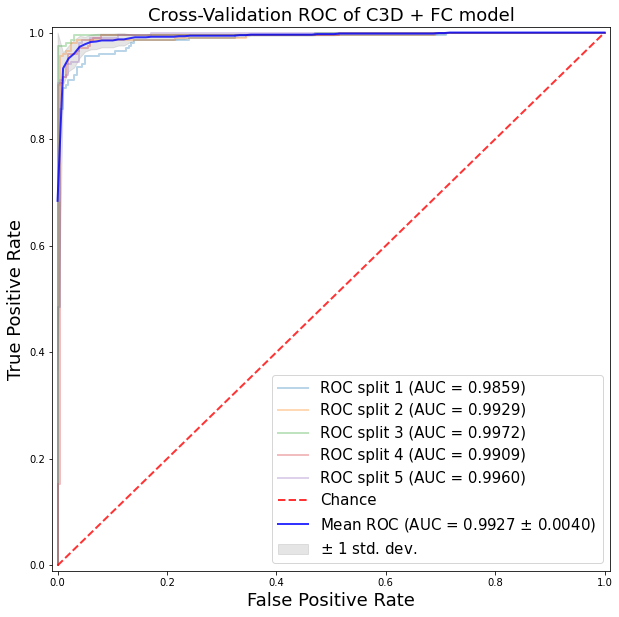

Losses
[[0.25558358]
 [0.09719883]
 [0.06752614]
 [0.12184606]
 [0.09605573]]
Accuracies
[[0.95273632]
 [0.97761196]
 [0.98258704]
 [0.96268654]
 [0.95771146]]
Sensitivities
[0.95544554 0.98019802 0.9950495  0.97029703 0.94554455]
specificities
[0.95  0.975 0.97  0.955 0.97 ]
F1-scores
[0.95308642 0.97777778 0.98288509 0.96314496 0.95739348]
Avg loss: 0.12764206975698472 +/- 0.06624354700576769
Avg accuracy: 0.9666666626930237 +/- 0.011518241898459299
Avg sensitivity: 0.9693069306930692 +/- 0.017544599155118187
Avg specificity: 0.9639999999999999 +/- 0.009695359714832668
Avg f1-score: 0.9668575459919346 +/- 0.011568311471442752


In [ ]:
# C3D + fully connected classification on the hockey fight dataset
runEndToEndExperiment(getC3DCNNModel, 32, '/hockeyFight', count_hockey_fight_chunks, '/hockeyFightMMaps', 'samples.mmap', 'labels.mmap', 'C3D + FC', 'C3D_FC_Hockey', 42)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 16, 112, 112, 3)] 0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    176

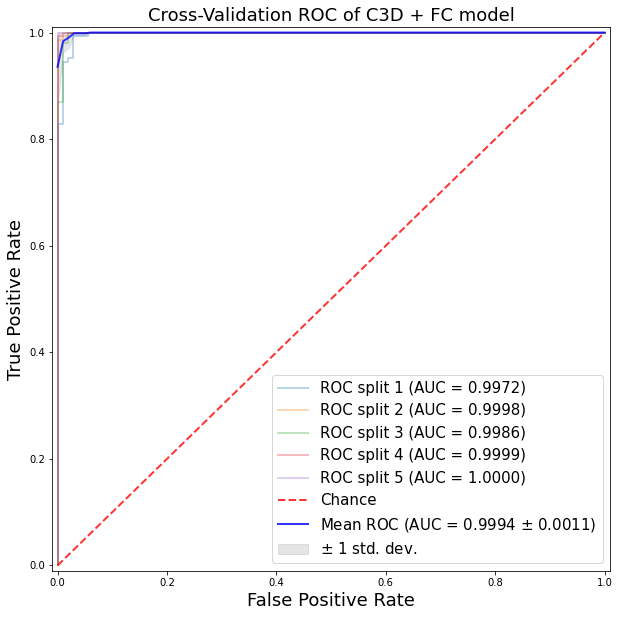

Losses
[[0.09094819]
 [0.01605412]
 [0.05348336]
 [0.01067632]
 [0.00698199]]
Accuracies
[[0.98418975]
 [0.99209487]
 [0.98418975]
 [0.99604744]
 [0.99604744]]
Sensitivities
[0.99315068 1.         0.98630137 1.         1.        ]
specificities
[0.97196262 0.98130841 0.98130841 0.99065421 0.99065421]
F1-scores
[0.98639456 0.99319728 0.98630137 0.99658703 0.99658703]
Avg loss: 0.03562879683449864 +/- 0.03226594114860111
Avg accuracy: 0.9905138492584229 +/- 0.00536151704992039
Avg sensitivity: 0.9958904109589041 +/- 0.005479452054794542
Avg specificity: 0.9831775700934579 +/- 0.006993752124811106
Avg f1-score: 0.991813453606231 +/- 0.004631124011202398


In [ ]:
# C3D + fully connected classification on the crowd violence dataset
runEndToEndExperiment(getC3DCNNModel, 32, '/crowdViolence', count_crowd_violence_chunks, '/crowdViolenceMMaps', 'samples.mmap', 'labels.mmap', 'C3D + FC', 'C3D_FC_Crowd', 42)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 110, 110, 64)      154624    
_________________________________________________________________
dropout_44 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 774400)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               198246656 
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 198,401,537
Trainable params: 198,401,537
Non-trainable params: 0
_______________________________________

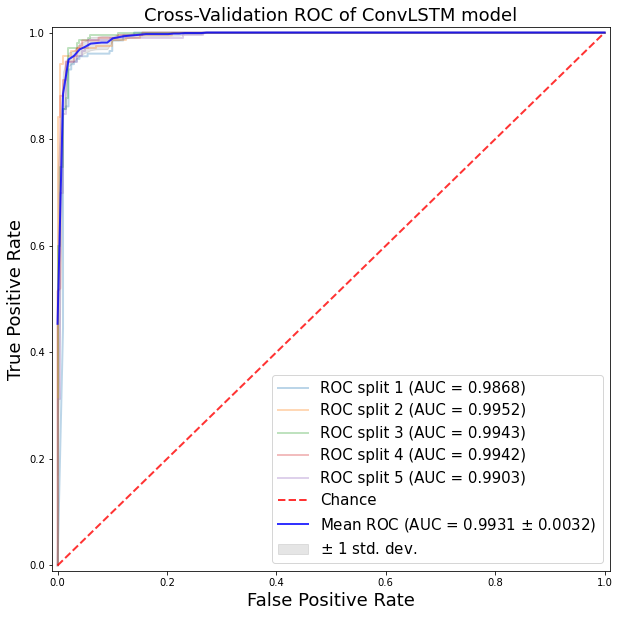

Losses
[[0.31414786]
 [0.08859676]
 [0.09438292]
 [0.11765737]
 [0.1311202 ]]
Accuracies
[[0.95771146]
 [0.97263682]
 [0.97512436]
 [0.96766168]
 [0.95522386]]
Sensitivities
[0.95544554 0.95544554 0.97029703 0.98514851 0.95544554]
specificities
[0.96  0.99  0.98  0.95  0.955]
F1-scores
[0.95781638 0.97229219 0.97512438 0.96836983 0.95544554]
Avg loss: 0.14918102324008942 +/- 0.08391337912043927
Avg accuracy: 0.9656716346740722 +/- 0.007929041628461236
Avg sensitivity: 0.9643564356435643 +/- 0.011881188118811892
Avg specificity: 0.967 +/- 0.01536229149573723
Avg f1-score: 0.9658096641909181 +/- 0.007831335970740113


In [ ]:
# ConvLSTM architecture on the Hockey Fight dataset (the model is trained end-to-end)
runEndToEndExperiment(getLSTMModel, 8, '/hockeyFight', count_hockey_fight_chunks, '/hockeyFightMMaps', 'samples.mmap', 'labels.mmap', 'ConvLSTM', 'ConvLSTM_Hockey', 42) 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_5 (ConvLSTM2D)  (None, 110, 110, 64)      154624    
_________________________________________________________________
dropout_54 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 774400)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               198246656 
_________________________________________________________________
dropout_55 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 198,401,537
Trainable params: 198,401,537
Non-trainable params: 0
_______________________________________

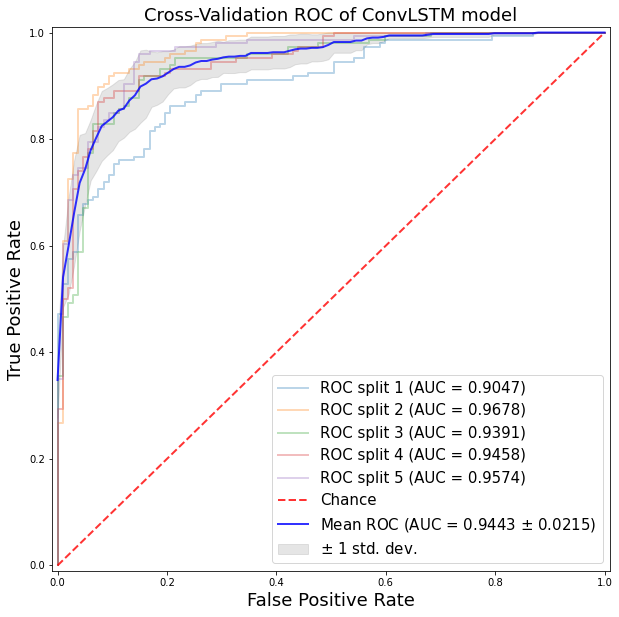

Losses
[[0.48448575]
 [0.28759715]
 [0.37795979]
 [0.31949529]
 [0.29773366]]
Accuracies
[[0.73517787]
 [0.88932806]
 [0.83399212]
 [0.84584981]
 [0.90513831]]
Sensitivities
[0.97260274 0.94520548 0.95205479 0.93150685 0.95890411]
specificities
[0.41121495 0.81308411 0.6728972  0.72897196 0.8317757 ]
F1-scores
[0.80911681 0.90789474 0.86875    0.87459807 0.92105263]
Avg loss: 0.35345432758331297 +/- 0.07261532404055081
Avg accuracy: 0.8418972373008728 +/- 0.05952520976463891
Avg sensitivity: 0.9520547945205481 +/- 0.013698630136986311
Avg specificity: 0.6915887850467289 +/- 0.15150567573203322
Avg f1-score: 0.8762824496554824 +/- 0.038921726810985095


In [ ]:
# ConvLSTM architecture on the Crowd Violence dataset (the model is trained end-to-end)
runEndToEndExperiment(getLSTMModel, 8, '/crowdViolence', count_crowd_violence_chunks, '/crowdViolenceMMaps', 'samples.mmap', 'labels.mmap', 'ConvLSTM', 'ConvLSTM_Crowd', 42) 